In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from scipy.ndimage.filters import gaussian_filter
from collections import Counter, defaultdict
from typing import List, Dict
import xarray as xr
import itertools
import logging
import joblib
import random
import yaml
import sys
import cv2
import os

import pandas as pd
import numpy as np

import logging
import transforms

import tensorflow as tf
from tensorflow.keras.utils import Sequence

import matplotlib.pyplot as plt

### See [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) for an example on using Sequence with multiprocessing

In [2]:
logger = logging.getLogger(__name__)

In [3]:
class MultiHologramDataset(Sequence):

    def __init__(
            self,
            path_data: List[str],
            output_cols: List[str],
            batch_size: int = 32,
            max_particles: int = 100,
            shuffle: bool = True,
            scaler: Dict[str, str] = True,
            transform = None) -> None:
        
        'Initialization'
        self.ds = {name: xr.open_dataset(name) for name in path_data}
        
        'Load the filenames from the config file'
        self.hologram_numbers = []
        for name, _ds in sorted(self.ds.items()):
            for hologram_number in _ds["hologram_number"].values:
                self.hologram_numbers.append([name, hologram_number])
        
        self.output_cols = [x for x in output_cols if x != 'hid']  
        self.max_particles = max_particles
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.transform = transform
        self.on_epoch_end()
        
        self.scaler = None
        self.set_scaler(scaler)

        logger.info(
            f"Loaded {path_data} hologram data containing {len(self.hologram_numbers)} images"
        )
        
    def set_scaler(self, scaler = True):
        if scaler == True:
            logger.info(f"Rescaling the data by subtracting the mean and dividing by sigma")
            self.scaler = {col: StandardScaler() for col in self.output_cols}  # StandardScaler() MinMaxScaler()
            for col in self.output_cols:
                concat = [arr[col].values for arr in self.ds.values()]
                scale = np.hstack(concat)
                self.scaler[col].fit(scale.reshape(scale.shape[-1], -1))
        elif scaler == False:
            self.scaler = False
        else:
            self.scaler = scaler
        logger.info(f"Loaded data scaler transformation {self.scaler}")

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.hologram_numbers) / self.batch_size))

    def __getitem__(self, idx):    
        'Generate one data point'
        name, hologram = self.hologram_numbers[idx]

        'Update the counter'
        self.processed += 1
        if self.processed == self.__len__():
            self.on_epoch_end()

        im = self.ds[name]["image"][hologram].values
        im = {
            "image": np.expand_dims(im, 0), 
            "horizontal_flip": False, 
            "vertical_flip": False
        }

        'Apply image transformations listed in the config file'
        if self.transform:
            for image_transform in self.transform:
                im = image_transform(im)

        'Load one hologram and get the particles'
        particles = np.where(self.ds[name]["hid"] == hologram + 1)[0]
        y_out = {task: np.zeros((self.max_particles)) for task in self.output_cols}
        for l, p in enumerate(particles):
            indices = []
            for task in self.output_cols:
                val = self.ds[name][task].values[p]
                if im["horizontal_flip"] and task == "x":
                    val *= -1
                if im["vertical_flip"] and task == "y":
                    val *= -1
                'Scaler transform the y-out data'
                if isinstance(self.scaler, dict):
                    val = self.scaler[task].transform(val.reshape(-1, 1))[0][0]
                y_out[task][l] = val

        'Return as numpy arrays'
        image = im["image"]
        y_out = np.stack(list(y_out.values()))
        #image = tf.convert_to_tensor(im["image"])
        #y_out = tf.convert_to_tensor(np.stack(list(y_out.values())))
        return image, y_out

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.processed = 0
        if self.shuffle == True:
            random.shuffle(self.hologram_numbers)

In [4]:
 with open("data.yml") as config_file:
    conf = yaml.load(config_file, Loader=yaml.FullLoader)

### Load the image transformations from the config files

In [5]:
train_transforms = transforms.LoadTransformations(conf["train_transforms"])
valid_transforms = transforms.LoadTransformations(conf["validation_transforms"])

### Initialize the data readers

In [6]:
train_reader = MultiHologramDataset(
    **conf["train_data"],
    transform = train_transforms
)

# Save the scaler to file here 

valid_reader = MultiHologramDataset(
    **conf["validation_data"],
    transform = train_transforms,
    scaler = train_reader.scaler
)

### Get one item

In [7]:
x, y = train_reader.__getitem__(1)

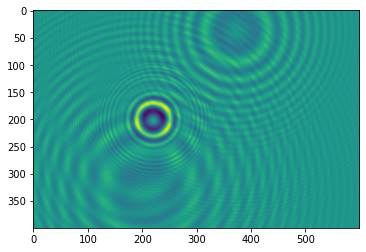

In [8]:
plt.imshow(x.squeeze(0).transpose(1, 0))

### Train model on dataset

In [69]:
# model.fit_generator(generator=train_reader,
#                     validation_data=valid_reader,
#                     use_multiprocessing=True,
#                     steps_per_epoch = 2000,
#                     workers=8)